In [1]:
import sys
import yaml
import numpy as np
from pathlib import Path
import hydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig
import os

sys.path.append('../')

In [2]:
from omegaconf import OmegaConf


config_dir = os.path.abspath('../conf')
with initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = compose(config_name="config", overrides=["data=base"])

cfg

{'data': {'type': 'new', 'policy': 'random-discrete', 'out_dir': 'data/', 'signal_dim': 2, 'static_noise_dim': 0, 'memoryless_noise_dim': 0, 'state_dim': 100, 'mlp_hidden_dim': 100, 'traj_len': 20, 'num_actions': '???', 'seed': 0, 'step_size': 0.3, 'n_train': 1000, 'n_val': 100, 'n_test': 100}, 'model': {'vae': {'z_dim': 30, 'enc_widths': [256, 256], 'dec_widths': [256, 256], 'activation': 'relu', 'beta': 0.001}, 'contrastive': {'z_dim': 30, 'enc_widths': [256, 256], 'proj_widths': [256, 256], 'activation': 'relu', 'temperature': 3.0, 'use_layer_norm': True, 'eps': 1e-05, 'alpha': None, 'k': 1}, 'dynamics': {'dyn_widths': [256, 256], 'activation': 'relu'}, 'probe': {'probe_widths': [64, 64], 'activation': 'relu'}, 'repr': '${oc.select:model.${method}}'}, 'train': {'epochs_phase1': 100, 'epochs_phase2': 100, 'epochs_probe': 100, 'num_workers': 0, 'ckpt_dir': 'ckpts/', 'eval_batch_size': 512, 'device': 'mps', 'vae': {'lr': 0.002, 'batch_size': 256, 'weight_decay': 0.0, 'gradient_clip': {

In [3]:
from scripts.generate_data import main as gen_main
from utils import check_config

check_config(cfg)


In [4]:
gen_main(cfg)

shapes. obs: (2000, 100) action: (2000, 1) signal: (2000, 2) state: (2000, 2)
obs mean/std: 1.7344952e-10 1.0
signal mean/std: -0.010444978 1.1778383
state mean/std: -0.010444978 1.1778383
actions min/max/unique: 0.0 3.0 (array([0., 1., 2., 3.], dtype=float32), array([477, 497, 499, 527]))


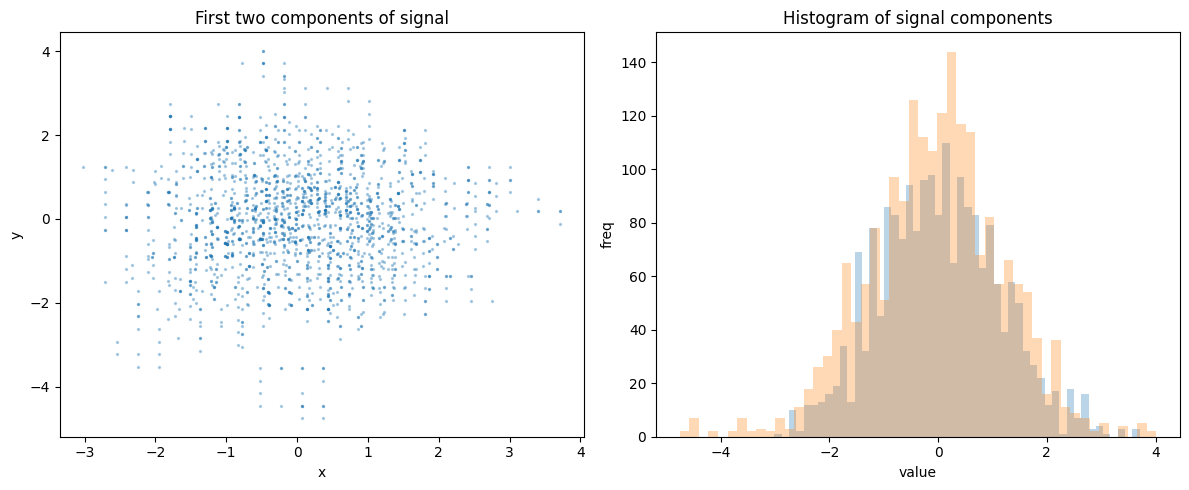

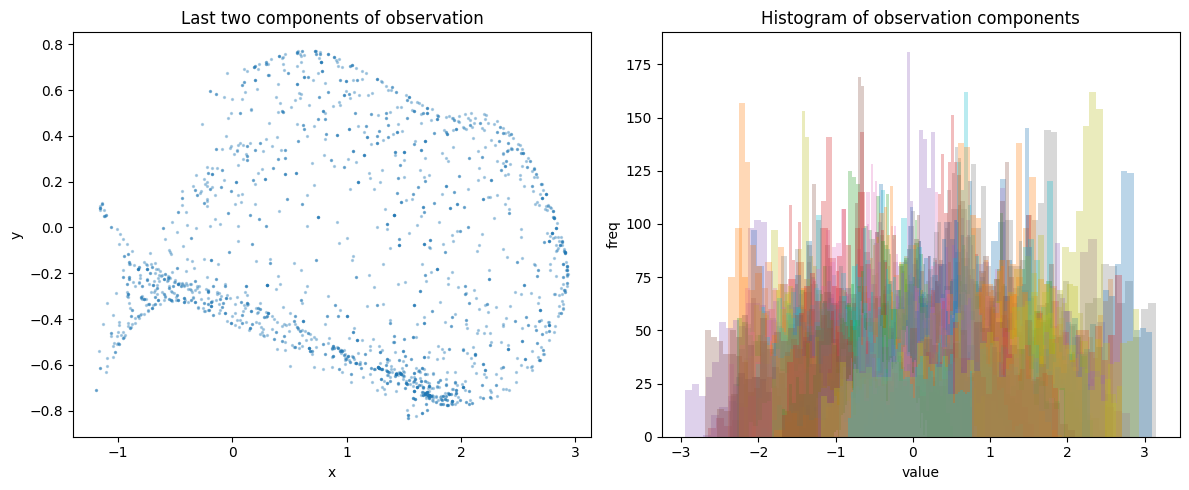

In [5]:
import matplotlib.pyplot as plt
from data import TransitionDataset

data_dir = Path(cfg['data']['out_dir'])
split = "val"
data = TransitionDataset((data_dir / f'{split}.npz'))

obs, action, obs_next, signal, signal_next, state, state_next = data.observation.numpy(), data.action.numpy(), data.observation_next.numpy(), data.signal.numpy(), data.signal_next.numpy(), data.state.numpy(), data.state_next.numpy()
print(f"shapes. obs: {obs.shape} action: {action.shape} signal: {signal.shape} state: {state.shape}")

print("obs mean/std:", obs.mean(), obs.std())
print("signal mean/std:", signal.mean(), signal.std())
print("state mean/std:", state.mean(), state.std())
print("actions min/max/unique:", action.min(), action.max(), np.unique(action, return_counts=True))

N = min(10000, obs.shape[0])
idx = np.random.choice(obs.shape[0], N, replace=False)

# explore signal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(signal[idx,0], signal[idx,1], s=2, alpha=0.3)
axes[0].set_title("First two components of signal")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
for i in range(signal.shape[1]):
    axes[1].hist(signal[idx, i], bins=50, alpha=0.3, label=f'signal-{i}')
axes[1].set_title("Histogram of signal components")
axes[1].set_xlabel("value")
axes[1].set_ylabel("freq")
plt.tight_layout()
plt.show()

# explore observation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(obs[idx,-2], obs[idx,-1], s=2, alpha=0.3)
axes[0].set_title("Last two components of observation")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
for i in range(obs.shape[1]):
    axes[1].hist(obs[idx, i], bins=50, alpha=0.3, label=f'obs-{i}')
axes[1].set_title("Histogram of observation components")
axes[1].set_xlabel("value")
axes[1].set_ylabel("freq")
plt.tight_layout()
plt.show()

In [8]:
from data import discrete2continuous_action

a_discrete, a_cont = discrete2continuous_action(
    a_discrete=action,
    signal_dim=cfg.data.signal_dim,
    step_size=cfg.data.step_size,
)

In [9]:
err = np.max(np.abs(signal_next - (signal + a_cont)) / np.abs(signal + a_cont))
print(err)
assert err < 1e-3

2.328614e-06
